In [1]:
import os
import time
import pickle
import wandb
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tfc

from PIL import Image,ImageOps
from tqdm import tqdm
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras import callbacks
from wandb.keras import WandbCallback

In [2]:
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
try: sess.close() 
except: pass

tfc.enable_eager_execution()
print(f"eagely execution: {tf.executing_eagerly()}")

gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1
Found GPU at: /device:GPU:0
eagely execution: True


## CONSTANTS

In [3]:
IMG_SIZE = 128
CHANNELS = 1
INPUT_SHAPE = [218,145,CHANNELS]
#INPUT_SHAPE = [IMG_SIZE,IMG_SIZE,CHANNELS]

BATCH_SIZE = 64
EPOCHS = 300

NAME = f"O_CNN{int(time.time())}"
SOURCE = "train_images/"
RES = f"train_images_res_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}/"

### Callbacks

In [4]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)

## Adjust CSV

In [5]:
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)


images = train_df['image']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


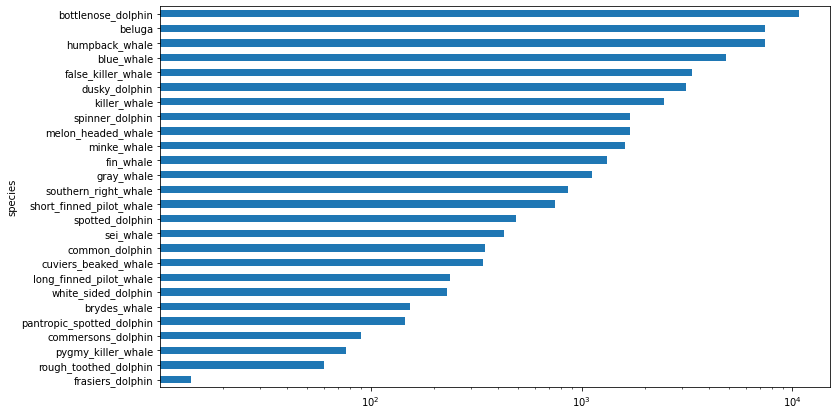

In [6]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

### Adjust for class imbalance

In [7]:
thresh = 200
max_instances = None

In [8]:
def undersample(df, index, max_instances):
    if max_instances is not None:
        sampled = df[df.species == index].sample(n=max_instances, random_state=101) if len(df[df.species == index]) > max_instances else df[df.species == index]
    else:
        sampled = df[df.species == index]
    return  sampled

In [9]:
#train_df.species = train_df.species.apply(lambda x: 'other_dolphin' if ('dolphin' in x and not "bottlenose" in x) else x)
species_counts = train_df['species'].value_counts()


final_species = species_counts[species_counts > thresh].index.tolist()
mask = train_df.species.apply(lambda x: any(item for item in final_species if item in x))
final_df = train_df[mask]

In [10]:
dfs = []
for species in final_species:
    dfs.append(undersample(final_df,species,max_instances))

final_train_df = pd.concat(dfs,axis=0).sort_index()
final_train_df["species"].value_counts()

train_df=final_train_df
species_labels = list(train_df.species.unique())

### Encoding species

In [11]:
def get_id(sp,labels):
    return labels.index(sp)


names = train_df["species"].unique()
train_df["species"] = train_df.apply(lambda row :get_id(row["species"],species_labels),axis = 1)
labels = train_df["species"]

AMT_CLASSES = len(labels.unique())

In [12]:
##one-hot encode species
"""
labels = pd.get_dummies(train_df.species, prefix='species_')
labels
train_df = pd.concat([train_df,labels],axis = 1)

val_counts = []
for sp in labels.columns:
    val_counts.append(labels[sp].value_counts()[1])
print(val_counts)

AMT_CLASSES = labels.shape[1]
"""

"\nlabels = pd.get_dummies(train_df.species, prefix='species_')\nlabels\ntrain_df = pd.concat([train_df,labels],axis = 1)\n\nval_counts = []\nfor sp in labels.columns:\n    val_counts.append(labels[sp].value_counts()[1])\nprint(val_counts)\n\nAMT_CLASSES = labels.shape[1]\n"

In [13]:
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Resize Images
This helps the model fitting --> picture preprocessing gets less intensive

In [14]:
def image_filet(im):
    #Kernel exclusion and image processing
    img = np.asarray(im)
    gauss = cv2.GaussianBlur(img, (0, 0), 2.0)
    img = cv2.addWeighted(img, 1, gauss, 0, 0)
    
    img = cv2.GaussianBlur(img,(9,9),2.0)
    kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    return Image.fromarray(img)


if not os.path.exists(RES):
    os.mkdir(RES)
for image in tqdm(images):
    savePath = RES + image  
    if not os.path.exists(savePath):
        im = Image.open(SOURCE + image)
        im = ImageOps.grayscale(im) if CHANNELS == 1 else im


        im.thumbnail((INPUT_SHAPE[:2]), Image.ANTIALIAS)
        im = ImageOps.pad(im, (INPUT_SHAPE[:2]), color='black')
        im.save(savePath)

        #im = image_filet(im)
        #resizedImage = im.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        #resizedImage.save(savePath) 
            

100%|██████████████████████████████████████████████████████████████████████████| 51033/51033 [00:06<00:00, 7599.72it/s]


In [15]:
full_img = list(map(RES.__add__,train_df['image']))

## Input Pipeline

In [16]:
@tf.function
def process_tuple(image,label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_contrast(img, 0.1, 1.1, seed=None)

    img = tf.image.convert_image_dtype(img, tf.float16)
    return img, label

In [17]:
TRAIN_SPLIT = 0.8
VAL_TEST_SPLIT = (1-TRAIN_SPLIT)/2

In [18]:
train_even_df, val_even_df, test_even_df = pd.read_pickle("train_ds.pickle").sort_index(), pd.read_pickle("val_ds.pickle").sort_index(), pd.read_pickle("test_ds.pickle").sort_index()
print(f"train:{len(train_even_df)} val:{len(val_even_df)} test:{len(test_even_df)}")

train:40388 val:5037 test:5069


In [19]:
train_label = list(train_even_df["species"].values)
train_img = list(map(RES.__add__,train_even_df["image"]))
train_ds = tf.data.Dataset.from_tensor_slices((train_img,train_label)).shuffle(1000, seed = 1337).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

val_label = list(val_even_df["species"].values)
val_img = list(map(RES.__add__,val_even_df["image"]))
val_ds = tf.data.Dataset.from_tensor_slices((val_img,val_label)).shuffle(1000, seed = 1337).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

test_label = list(test_even_df["species"].values)
test_img = list(map(RES.__add__,test_even_df["image"]))
test_ds = tf.data.Dataset.from_tensor_slices((test_img,test_label)).shuffle(1000, seed = 1337).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [20]:
"""
label_dss = []
val_ds, test_ds = None, None
comp_tr, comp_vt = 0, 0

for label in labels.columns:
    query = train_df.query(f"{label} == 1")
    query = query.sample(frac = thresh/len(query), replace = True)
    
    
    img_paths = list(map(RES.__add__,query['image']))
    
    tr_size = int(len(query)*TRAIN_SPLIT)
    comp_tr += tr_size
    vt_size = int(len(query)*VAL_TEST_SPLIT)-1
    comp_vt += vt_size
    
    label_ds = tf.data.Dataset.from_tensor_slices((img_paths, query[labels.columns])).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    val_ds = label_ds.skip(tr_size).take(vt_size) if not val_ds else val_ds.concatenate(label_ds.skip(tr_size).take(vt_size))
    test_ds = label_ds.skip(tr_size).skip(vt_size) if not test_ds else test_ds.concatenate(label_ds.skip(tr_size).skip(vt_size))

    label_dss.append(label_ds.take(tr_size))

    
train_ds = tf.data.Dataset.sample_from_datasets(label_dss, weights=[1/len(label_dss)]*len(label_dss))




--------------------------------------------------------------




for label in range(len(train_even_df.species.unique())):
    query = train_even_df.query(f'species == {label}').sample(frac=1)
    len_cut_ds_list.append(len(query))
    full_img = list(map((TRAIN_DIR + "train_images_sized/").add, query['image']))

    label_dataset = tf.data.Dataset.from_tensor_slices((full_img, query["species"])).shuffle(1000, seed=1337).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
    train_datasets_by_label.append(label_dataset)



train_ds = tf.data.Dataset.sample_from_datasets(train_datasets_by_label, weights=[1/len(train_datasets_by_label)]*len(train_datasets_by_label))
"""

'\nlabel_dss = []\nval_ds, test_ds = None, None\ncomp_tr, comp_vt = 0, 0\n\nfor label in labels.columns:\n    query = train_df.query(f"{label} == 1")\n    query = query.sample(frac = thresh/len(query), replace = True)\n    \n    \n    img_paths = list(map(RES.__add__,query[\'image\']))\n    \n    tr_size = int(len(query)*TRAIN_SPLIT)\n    comp_tr += tr_size\n    vt_size = int(len(query)*VAL_TEST_SPLIT)-1\n    comp_vt += vt_size\n    \n    label_ds = tf.data.Dataset.from_tensor_slices((img_paths, query[labels.columns])).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)\n    val_ds = label_ds.skip(tr_size).take(vt_size) if not val_ds else val_ds.concatenate(label_ds.skip(tr_size).take(vt_size))\n    test_ds = label_ds.skip(tr_size).skip(vt_size) if not test_ds else test_ds.concatenate(label_ds.skip(tr_size).skip(vt_size))\n\n    label_dss.append(label_ds.take(tr_size))\n\n    \ntrain_ds = tf.data.Dataset.sample_from_datasets(label_dss, weights=[1/len(label_dss)]

In [21]:
train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_batched = val_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### Benchmark Dataset

In [22]:
def benchmark(dataset, num=2):
    start_time = time.perf_counter()
    for n in range(num):
        for sample in tqdm(dataset):
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [23]:
if tf.executing_eagerly(): 
    benchmark_tr = train_ds.take(1)
    benchmark(benchmark_tr)


    benchmark_val = val_ds.take(1)
    benchmark(benchmark_tr)

    benchmark_test = test_ds.take(1)
    benchmark(benchmark_tr)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.11it/s]


Execution time: 0.14079879999917466


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.38it/s]


Execution time: 0.126070800000889


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.11it/s]

Execution time: 0.1263165000018489


## Modelling

#### WandB

In [24]:
run = wandb.init(project="my-test-project",
           entity="dolphin_project",
           sync_tensorboard = True,
           config={
               "learning_rate": 0.0002,
               "beta1":0.9,
               "beta2":0.999,
               "epsilon": 1e-08,
               "batch_size": BATCH_SIZE,
               "epochs": EPOCHS,
               "input_width": INPUT_SHAPE[0],
               "input_height": INPUT_SHAPE[1],
               "loss_function": "sparse_categorical_crossentropy",
               "architecture": "CNN-flatten",
               "dataset": "dolphin",
               #"activation": ACTIVATION_STR,
               #"conv_units": [FIRST_CONV_UNITS, SECOND_CONV_UNITS] + CONV_UNITS_BODY,
           })
config = wandb.config

wandb: Currently logged in as: dolphin_project (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


#### Compute Class-Weights

In [25]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = 'balanced', classes = labels.unique(), y=labels)
class_weights = dict(enumerate(class_weights))

#### Model Keras

In [26]:
import stefan_cnn_v3

In [27]:
scnn = stefan_cnn_v3.create_model(INPUT_SHAPE, AMT_CLASSES)

current_model = scnn
    
current_model.summary()
current_model.compile(loss=config.loss_function,
             optimizer=keras.optimizers.Adam(config.learning_rate),
             metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 145, 218, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 145, 218, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 73, 109, 16)  160         ['sequential[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 73, 109, 16)  64         ['conv2d[0][0]']             

In [ ]:
history = current_model.fit(train_batched,
                    class_weight = class_weights,
                    epochs = EPOCHS,
                    validation_data = val_batched,
                    callbacks=[WandbCallback(input_type="image",  labels=names),
                              TensorBoard(log_dir=wandb.run.dir),
                              earlystopping                           
                             ])
wandb.watch(history)

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Epoch 1/300
  6/632 [..............................] - ETA: 4:29 - loss: 0.5719 - accuracy: 0.7448WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1153s vs `on_train_batch_end` time: 0.3205s). Check your callbacks.


631/632 [============================>.] - ETA: 0s - loss: 0.5642 - accuracy: 0.7564

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


632/632 [==============================] - 283s 447ms/step - loss: 0.5641 - accuracy: 0.7565 - val_loss: 1.5491 - val_accuracy: 0.5821
Epoch 2/300
632/632 [==============================] - 279s 441ms/step - loss: 0.5575 - accuracy: 0.7581 - val_loss: 1.3867 - val_accuracy: 0.6226
Epoch 3/300
632/632 [==============================] - 298s 472ms/step - loss: 0.5647 - accuracy: 0.7550 - val_loss: 1.6567 - val_accuracy: 0.5630
Epoch 4/300
632/632 [==============================] - 329s 521ms/step - loss: 0.5429 - accuracy: 0.7612 - val_loss: 1.3100 - val_accuracy: 0.6448
Epoch 5/300
631/632 [============================>.] - ETA: 0s - loss: 0.5584 - accuracy: 0.7584

In [29]:
current_model.save("oliver_final_class-weights")

INFO:tensorflow:Assets written to: oliver_final_class-weights\assets


INFO:tensorflow:Assets written to: oliver_final_class-weights\assets


### Predict + Evaluate Model

In [29]:
pr = current_model.predict(test_batched)

 1/80 [..............................] - ETA: 44sWARNING:tensorflow:From C:\Users\Oliver\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\eager\function.py:113: TypeSpec.most_specific_compatible_type (from tensorflow.python.framework.type_spec) is deprecated and will be removed in a future version.
Instructions for updating:
Use most_specific_common_supertype instead.
80/80 [==============================] - 18s 214ms/step


In [30]:
y_test = np.array(test_label)
y_pred = pr.argmax(axis=1)

#y_act = y_test.values.argmax(axis=1)  #--> used if one-hot encoded
y_act = y_test

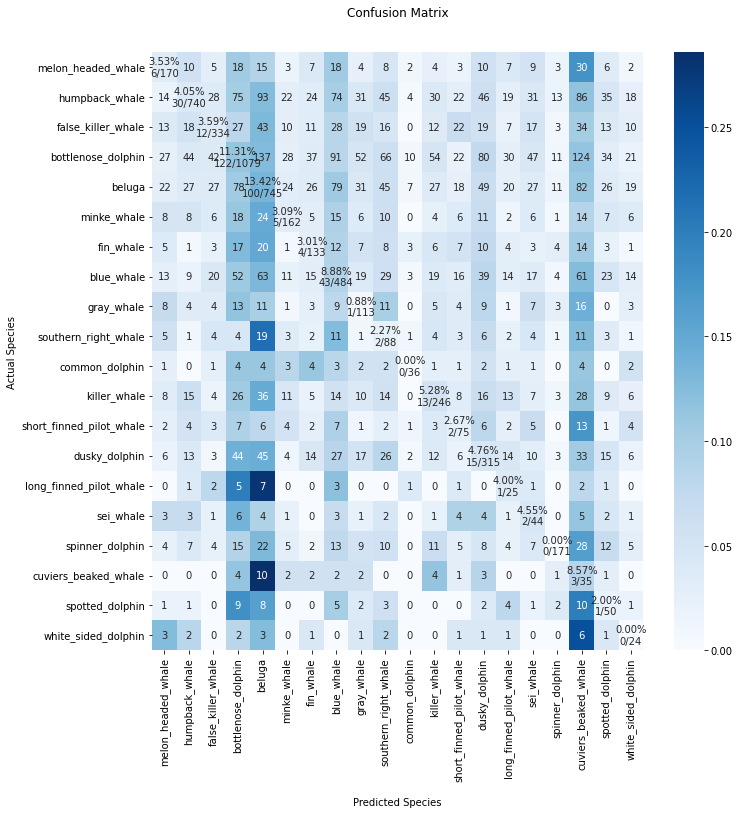

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#sp_list = list(map(lambda x: x.split("species__")[-1],labels))#--> used if one-hot encoded

cm=confusion_matrix(y_act,y_pred)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

plt.figure(figsize=(11, 11))

annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
        else:
            annot[i, j] = '%d' % (c)
            
cm=confusion_matrix(y_act,y_pred,normalize='true')            
cm = pd.DataFrame(cm, index=names, columns=names)

ax = sns.heatmap(cm, annot=annot, fmt='', cbar=True, cmap="Blues")

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Species')
ax.set_ylabel('Actual Species')

ax.xaxis.set_ticklabels(names,rotation = 90)
ax.yaxis.set_ticklabels(names, rotation = 360)


plt.show()

In [32]:
cval = current_model.evaluate(test_batched, verbose = 0)

In [33]:
wandb.log({"test loss" : cval[0]})
wandb.log({"test acc" : cval[1]})
wandb.log({"test error rate" : round((1-cval[1])*100,2)})
run.finish()

accuracy,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
test acc,▁
test error rate,▁
test loss,▁
val_accuracy,▁▃▄▃▃▄▄▅▅▅▅▆▆▆▇▆▆▆▇▇▆▇▇██▇▇▇▇▇███▇▇▇▇█▇
val_loss,█▆▅▆▅▄▄▄▃▄▃▃▃▄▃▃▄▃▃▃▃▂▂▂▄▃▂▂▂▂▂▁▂▂▂▂▂▁▂
accuracy,0.61853
best_epoch,37
best_val_loss,1.43576


In [34]:
print("test loss, test acc:", cval)

test loss, test acc: [1.7937010526657104, 0.5375813841819763]


In [ ]:
with open(f'sv3nn.pkl', 'wb') as file:
    pickle.dump(current_model,file)

In [ ]:
"""

#visualize model performance
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize=(15, 8))
ax1.plot(range(87), accuracy, "r", label="Training Accuracy")
ax1.plot(range(87), val_accuracy, "orange", label="Validation Accuracy")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc="lower left")

ax2.plot(range(87), loss, "b", label="Training Loss")
ax2.plot(range(87), val_loss, "g", label="Validation Loss")
ax2.grid(True)
ax2.legend(loc="lower left")
#plt.gca().set_ylim(0, 2)
"""